In [12]:
from utils import *
import matplotlib.pyplot as plt

In [3]:
# path to input data directory
pin = '/home/adhamb/ironport_data'

# get file names
sender_file_names = find_files(pin, 'sender')
recipient_file_names = find_files(pin, 'recipient')

# construct sender and recipient dictionaries
sender_data = defaultdict(list)
for file_name in tqdm(sender_file_names, desc='sender data'):
    data = pd.read_pickle(file_name)
    for k, v in data.items():
        sender_data[k] += v

recipient_data = defaultdict(list)
for file_name in tqdm(recipient_file_names, desc='recipient data'):
    data = pd.read_pickle(file_name)
    for k, v in data.items():
        recipient_data[k] += v


recipient data: 100%|██████████| 62/62 [03:30<00:00,  3.40s/it]


In [7]:
# only consider emails that have sent and recieved messages.
# This potentially gets rid of all automatic emails too.
sender_users = list(sender_data.keys())
recipient_users = list(recipient_data.keys())
users = set(sender_users).intersection(set(recipient_users))
users = np.array(list(users))

In [9]:
# choose a subset of users that send and recieve between 100-200 emails
sent_received_count = [
    (u, len(sender_data[u]), len(recipient_data[u])) for u in users
]
sent_counts = np.array([src[1] for src in sent_received_count])
received_counts = np.array([src[2] for src in sent_received_count])

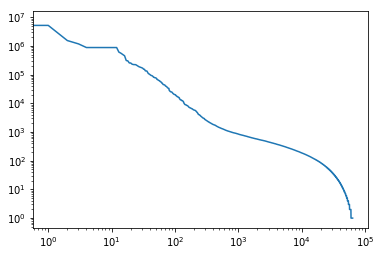

In [40]:
# plotting the 
idxs = sent_counts.argsort()[::-1]
y = sent_counts[idxs]
fig, ax = plt.subplots()
ax.plot(np.arange(y.shape[0]), y)
ax.set_xscale('log')
ax.set_yscale('log')

In [42]:
# cut the tail
idxs = sent_counts > 5
users = users[idxs]

In [69]:
users_mean = []
for user in tqdm(users):
    user_feats_mean = get_user_features(user, sender_data[user], recipient_data[user]).mean(0)
    users_mean.append(user_feats_mean) 

users_mean = np.array(users_mean)

In [151]:
kmeans = KMeans(n_clusters=5).fit(users_mean[:, 0].reshape(-1, 1))
yy = kmeans.labels_

In [161]:
(yy == 4).sum()

22

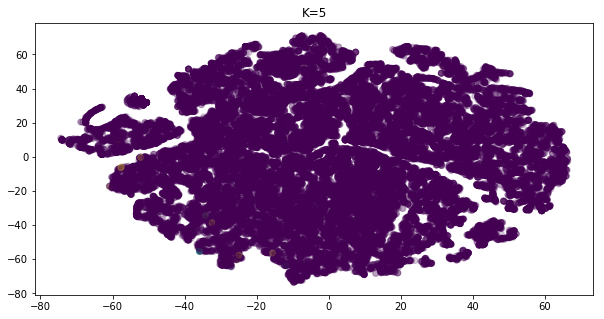

In [152]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tmp[:, 0], tmp[:, 1], c=yy, alpha=0.2)
ax.set_title('K=5')
fig.savefig('tsne_plot2.png')

In [76]:
from sklearn.manifold import TSNE
tmp = TSNE(n_components=2).fit_transform(users_mean)

In [139]:
users_mean2 = users_mean[:, [0, 12]]

In [142]:
tmp2 = TSNE(n_components=2).fit_transform(users_mean2)

KeyboardInterrupt: 

In [140]:
kmeans = KMeans(n_clusters=4).fit(users_mean2)
yy = kmeans.labels_

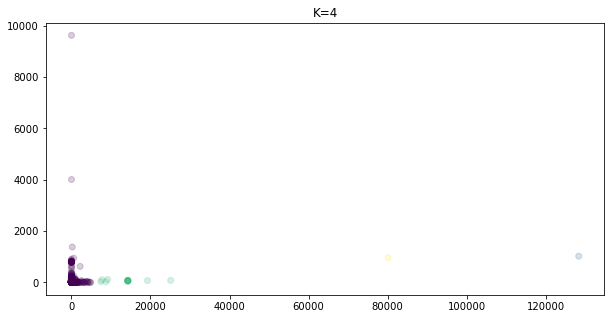

In [141]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(users_mean2[:, 0], users_mean2[:, 1], c=yy, alpha=0.2)
ax.set_title('K=4')
fig.savefig('tsne_plot2.png')

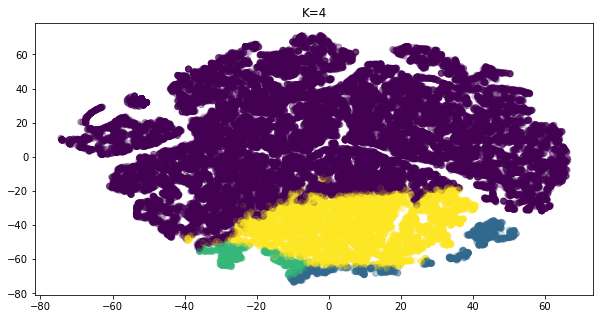

In [119]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tmp[:, 0], tmp[:, 1], c=yy, alpha=0.2)
ax.set_title('K=4')
fig.savefig('tsne_plot.png')

In [117]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(users_mean)

yy = kmeans.labels_

In [122]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(users_mean)
pca.explained_variance_ratio_.cumsum()

array([ 0.72548402,  0.95103554,  0.97408779,  0.99148972])

In [114]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(users_mean)
yy = kmeans.labels_

In [ ]:
>>> kmeans.labels_
array([0, 0, 0, 1, 1, 1], dtype=int32)
>>> kmeans.predict([[0, 0], [4, 4]])
array([0, 1], dtype=int32)
>>> kmeans.cluster_centers_
array([[ 1.,  2.],

In [129]:
feature_labels = [
    'number of sent emails',
    'statistics of sent emails\' size',
    'statistics of sent emails\' size',
    'statistics of sent emails\' size',
    'statistics of sent emails\' size',
    'statistics of number of recipients',
    'statistics of number of recipients',
    'statistics of number of recipients',
    'statistics of number of recipients',
    'number of unique recipients',
    'proportion of emails sent to telstra',
    'proportion of emails sent to outsie telstra',
    'number of received emails',
    'statistics of received emails\' size',
    'statistics of received emails\' size',
    'statistics of received emails\' size',
    'statistics of received emails\' size',
    'number of unique senders of received emails',
    'proportion of emails received from telstra',
    'proportion of emails received from outside telstra']

In [3]:
data = pd.read_pickle('parsed_data.pkl')
users = list(data['sender_data'].keys())

BETA = 0.05
TAU = 0.9

In [6]:
# date windows
window = 4
date_windows = []
n_windows = len(SPE) // (2*window) + 1
start = 0
for i in range(n_windows):
    end = start + 2*window
    date_windows.append((start, end))
    start = end

In [5]:
n_anomalies = []
for user in tqdm(users):
    user_send_data = data['sender_data'][user]
    user_receive_data = data['recipient_data'][user]
    features = get_user_features(user, user_send_data, user_receive_data)
    X = scale(features)
    SPE, Q = train_model(X, BETA, TAU)
    n_anomalies.append(count_anomalies(SPE, Q))

100%|██████████| 1683/1683 [00:30<00:00, 54.97it/s]


In [9]:
n_anomalies = np.array(n_anomalies)
user_idxs_to_report = np.where((n_anomalies > 3).sum(1) != 0)[0]

In [10]:
for user_idx in user_idxs_to_report:
    
    user = users[user_idx]

    user_send_data = data['sender_data'][user]
    user_receive_data = data['recipient_data'][user]
    features = get_user_features(user, user_send_data, user_receive_data)
    X = scale(features)
    SPE, Q = train_model(X, BETA, TAU)

    date_window = date_windows[np.argmax(count_anomalies(SPE, Q))]
    day_idxs = np.where(SPE>Q)[0]
    idxs = (day_idxs>=date_window[0]) & (day_idxs<date_window[1])
    days_to_report = day_idxs[idxs]

    print(user)
    for dd in days_to_report:
        print('Anomaly on {} due to {}'.format(
            pd.to_datetime('2017-07-{}'.format(dd+1)).date(),
            feature_labels[X[dd].argmax()]
            )
        )
    print()    

Sarah.Rediger@team.telstra.com
Anomaly on 2017-07-20 due to statistics of received emails' size
Anomaly on 2017-07-21 due to statistics of sent emails' size
Anomaly on 2017-07-22 due to statistics of received emails' size
Anomaly on 2017-07-24 due to statistics of sent emails' size

Nick.Martin@team.telstra.com
Anomaly on 2017-07-17 due to statistics of sent emails' size
Anomaly on 2017-07-19 due to proportion of emails sent to telstra
Anomaly on 2017-07-21 due to statistics of number of recipients
Anomaly on 2017-07-24 due to statistics of received emails' size

Sakshi.Rathore@team.telstra.com
Anomaly on 2017-07-03 due to statistics of sent emails' size
Anomaly on 2017-07-04 due to statistics of sent emails' size
Anomaly on 2017-07-05 due to statistics of sent emails' size
Anomaly on 2017-07-06 due to statistics of received emails' size

Rajashekar.Reddy@team.telstra.com
Anomaly on 2017-07-18 due to proportion of emails sent to telstra
Anomaly on 2017-07-19 due to statistics of receiv